In [87]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer , TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold , StratifiedKFold , StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
import warnings
warnings.filterwarnings("ignore")


# models 
from sklearn.naive_bayes import MultinomialNB
from catboost import CatBoostClassifier , Pool
from xgboost import XGBClassifier , DMatrix
from lightgbm import LGBMClassifier
import xgboost as xgb
from sklearn.ensemble import (
    AdaBoostClassifier,
    RandomForestClassifier,
    StackingClassifier,
    VotingClassifier,
    BaggingClassifier
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
import re
import nltk

In [88]:
train = pd.read_csv("Train.csv")
test = pd.read_csv("Test.csv")
sub = pd.read_csv("SampleSubmission.csv")

In [89]:
train['Label'].value_counts()[:17]

POLITICS                279
SOCIAL                  152
RELIGION                147
LAW/ORDER               136
SOCIAL ISSUES           134
HEALTH                  127
ECONOMY                  86
FARMING                  78
SPORTS                   49
EDUCATION                43
RELATIONSHIPS            39
WILDLIFE/ENVIRONMENT     36
OPINION/ESSAY            26
LOCALCHIEFS              25
CULTURE                  23
WITCHCRAFT               16
MUSIC                    15
Name: Label, dtype: int64

In [90]:
train = train[train['Label'].str.contains("|".join(list(train['Label'].value_counts()[:17].keys())))]

In [91]:
def cleanText(text):
#     text = re.sub(r"[^A-Za-z0-9]", " ", text)
#     text = re.sub(r'\b\d+(?:\.\d+)?\s+', '', text)
    text = re.sub('\n' , '' , text)
#     text = text.lower()
    return text

In [92]:
# len([x for x in train['Text'][0].split() if x.isupper()])
x = "Steve has Been the344re BE  BU"
"34".isdigit()

True

In [93]:
# Counter([x for x in train['Text'][0].split() if len(x)>3]).most_common(6)
# " ".join([x for x in train['Text'][0].split() if len(x)>3])

In [94]:
train['cleaned'] = train['Text'].apply(lambda text : " ".join([x for x in text.split() if len(x)>3]))
test['cleaned'] = test['Text'].apply(lambda text : " ".join([x for x in text.split() if len(x)>3]))




In [95]:
# function to create fetures
import string
from string import punctuation as is_punct
# len of words with more 
def getNumChar(text , cha ):
    return len(re.findall(cha , text))

def features(df):
    df['Text'] = df['Text'].apply(cleanText)
    df['str_length'] = df['Text'].apply(len)
    df['word_length'] = df['Text'].apply(lambda text: len([x for x in text.split()]))
    df['n_unique'] = df['Text'].apply(lambda text : len(set(x for x in text.split())))
    df['n_upper'] = df['Text'].apply(lambda text : len([x for x in text.split() if x.isupper()]))
    df['n_title'] = df['Text'].apply(lambda text : len([x for x in text.split() if x.istitle()]))
    df['n_caps'] = df['Text'].apply(lambda text : len([x for x in text if x.isupper()]))
    df['n_no_caps'] = df['Text'].apply(lambda text : len([x for x in text if not x.isupper()]))
    df['n_digits'] = df['Text'].apply(lambda text : len([x for x in text if x.isupper()]))

    for each_char in string.ascii_lowercase:
        df[f'{each_char}_char'] = df['Text'].apply(lambda x : getNumChar(x , each_char))
        # found len of numbers
    df['digit_count'] = df['Text'].apply(lambda x: len([w for w in re.findall(r'[0-9]+', str(x))]))
#     n caps following
    df['N_caps_follows'] = df['Text'].apply(lambda text: len([re.findall("[A-Z]{2,}" , text)]))
    # sum all digits
    
    df['sum_digit'] = df['Text'].apply(lambda x: sum([int(w) for w in re.findall(r'[0-9]+', str(x))]))
    # average digits
    df['average_digit'] = df['Text'].apply(lambda x: np.mean([int(w) for w in re.findall(r'[0-9]+', str(x))])).fillna(value =0)
    # Number of punctuations in the text ##
    df["num_punctuations"] =df['Text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )
    # Number of title case words in the text ##
    df["num_words_upper"] = df["Text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
    

    print('Features created')

In [96]:
features(test)
features(train)
train.head()

# is_punct

Features created
Features created


,ID,Text,Label,cleaned,str_length,word_length,n_unique,n_upper,n_title,n_caps,...,w_char,x_char,y_char,z_char,digit_count,N_caps_follows,sum_digit,average_digit,num_punctuations,num_words_upper
0,ID_AASHwXxg,Mwangonde: Khansala wachinyamata Akamati achi...,POLITICS,Mwangonde: Khansala wachinyamata Akamati achin...,2620,331,248,3,70,84,...,67,0,50,52,2,1,39,19.5,44,3
1,ID_AGoFySzn,MCP siidakhutire ndi kalembera Chipani cha Ma...,POLITICS,siidakhutire kalembera Chipani Malawi Congress...,2704,370,248,12,59,99,...,93,0,48,53,15,1,4185,279.0,53,12
2,ID_AGrrkBGP,Bungwe la MANEPO Lapempha Boma Liganizire Anth...,HEALTH,Bungwe MANEPO Lapempha Boma Liganizire Anthu A...,935,129,93,5,23,50,...,31,0,11,19,3,1,57,19.0,12,5
3,ID_AIJeigeG,Ndale zogawanitsa miyambo zanyanya Si zachile...,POLITICS,Ndale zogawanitsa miyambo zanyanya zachilendon...,3552,463,304,0,85,88,...,137,0,45,76,0,1,0,0.0,46,0
4,ID_APMprMbV,Nanga wapolisi ataphofomoka? Masiku ano sichi...,LAW/ORDER,Nanga wapolisi ataphofomoka? Masiku sichikhala...,371,45,43,0,5,5,...,15,0,4,2,0,1,0,0.0,8,0


In [97]:
labels = train['Label']
enc = LabelEncoder()
enc.fit(labels)

train['Label'] = enc.transform(labels)

labels = train['Label']

In [98]:
labels.shape

(1411,)

<AxesSubplot:xlabel='Label', ylabel='count'>

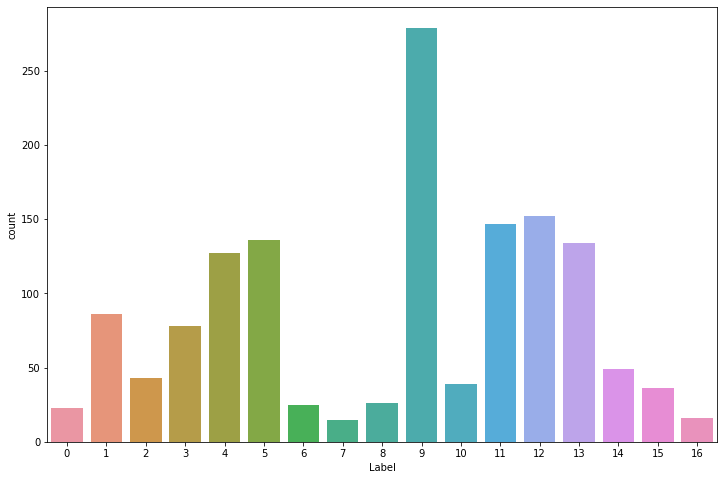

In [99]:
# train['Text'][0]
plt.figure(figsize =(12,8))
sns.countplot(train['Label'])

In [101]:
train['Label'].unique()



array([ 9,  4,  5, 11,  3, 15, 13, 12,  8,  6, 16,  1, 14, 10,  0,  2,  7])

In [188]:



from collections import Counter

In [189]:
# " ".join(list(train['Text']))

In [192]:
# A = train[train['Label'] !=11]

# A = pd.concat([A , train[train['Label'] ==11].sample(150)] , axis =0 )

In [191]:
# labels = A['Label']
# enc = LabelEncoder()
# enc.fit(labels)

# A['Label'] = enc.transform(labels)

# labels = A['Label']

In [102]:
vec = CountVectorizer(ngram_range=(1,1))
vec.fit(list(train['cleaned'])+list(test['cleaned']))
X = vec.transform(train['cleaned'])
test_df = vec.transform(test['cleaned'])


In [64]:
X # test_df.shape , X.shape 

<1411x63225 sparse matrix of type '<class 'numpy.int64'>'
	with 235129 stored elements in Compressed Sparse Row format>

In [103]:
def turnToDense(df):
    new_df = pd.DataFrame(df.todense())
    new_df.columns = ["cleaned_"+str(i)  for i in range(new_df.shape[1])]
    
    return new_df
    

In [104]:
train_df =train.drop(['ID' , "Label" , "Text" , "cleaned"] , axis =1).copy()
testdf =test.drop(['ID' , "Text" , "cleaned" ] , axis =1).copy()

In [105]:
train_df.shape , testdf.shape

((1411, 40), (620, 40))

In [106]:
# add the data to the datas
new_tr = turnToDense(X)
new_te = turnToDense(test_df)

new_te.shape , new_tr.shape

((620, 63225), (1411, 63225))

In [69]:
# len(new_tr.columns[new_tr.sum() < 20])
# new_tr[new_tr.columns[new_tr.sum() < 20]].sum(axis = 0)

In [107]:
train_df = pd.concat([train_df , new_tr[new_tr.columns[new_tr.sum() > 20]]] , axis =1)
testdf = pd.concat([testdf , new_te[new_tr.columns[new_tr.sum() > 20]]] , axis =1)
testdf['sumed'] = new_te[new_tr.columns[new_tr.sum() < 20]].sum(axis = 0).fillna(0)
train_df['sumed'] = new_tr[new_tr.columns[new_tr.sum() < 20]].sum(axis = 0).fillna(0)
train_df.shape , testdf.shape

((1435, 2156), (620, 2156))

In [71]:
# from imblearn.over_sampling import SMOTE 

# sm = SMOTE(random_state=42 , k_neighbors =6)

# A , B = sm.fit_resample(train_df , train['Label'])

In [72]:
np.array(train['Label'].value_counts)

array(<bound method IndexOpsMixin.value_counts of 0        9
1        9
2        4
3        9
4        5
        ..
1430     4
1432     9
1433     2
1434    13
1435     9
Name: Label, Length: 1411, dtype: int64>, dtype=object)

In [29]:
# sns.countplot(A['Label'])
# A[A['Label'] ==11].shape

In [150]:
# X.shape

In [30]:
list(testdf.columns) == list(train_df.columns)

True

In [108]:
X_train , Xval , y_train , yval =train_test_split(
#     train.drop(['ID' , "Text" , "Label","cleaned"] , axis =1),
#     train_df , 
    X,
    train['Label'],
    random_state=2020,
    test_size=0.1
)

<AxesSubplot:xlabel='Label', ylabel='count'>

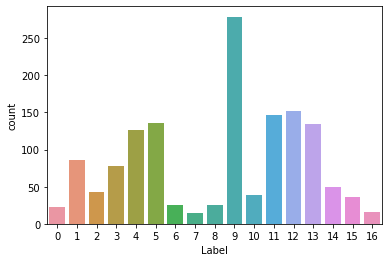

In [109]:
sns.countplot(train['Label'])

In [34]:
# from sklearn.utils import class_weight
# # help(class_weight)
# wgt = class_weight.compute_class_weight('balanced' , train['Label'].unique() , train['Label'])

# aa = {}

# for i in range(14):
#     aa[i] = wgt[i]+12
# aa[10] = wgt[10]
# aa

In [111]:
# base model
from sklearn.naive_bayes import GaussianNB 
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

lr =LGBMClassifier(
#     penalty='l2',
#     tol = 0.05,
#     max_iter = 5000,
#     class_weight='balanced',
#     solver ='saga'
#     metric='acuracy',
#     logging_level="Silent",
#     learning_rate = 0.05,
#     n_estimators = 500,

)
from sklearn.linear_model import SGDClassifier

# sdg = BaggingClassifier(
#     SGDClassifier(loss = 'log', 
# #                    alpha = 0.01,
                    
#                     max_iter = 10000,
#                     tol = 0.001,
#                    penalty = "elasticnet", 
#                     class_weight = "balanced",
#                     random_state=2020,
#                     n_iter_no_change=100
# #                     eta0 =0.1
                    
# #                    l1_ratio = 0.15
#                    ) ,n_estimators=1200
# )

sdg =     SGDClassifier(loss = 'log', 
#                    alpha = 0.01,
                    
                    max_iter = 10000,
                    tol = 0.001,
                   penalty = "elasticnet", 
                    class_weight = "balanced",
                    random_state=2020,
                    n_iter_no_change=100
#                     eta0 =0.1
                    
#                    l1_ratio = 0.15
                   )
from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
sdg.fit(X_train , y_train)

preds = sdg.predict(Xval)

print(f"Accuracy score is  {accuracy_score(yval , preds)}")

Accuracy score is  0.6690140845070423


In [50]:
from sklearn import linear_model

In [110]:
from sklearn.neural_network import MLPClassifier


clf = MLPClassifier(
#     solver="sgd",
#     activation="tanh",
#     hidden_layer_sizes =(120 ,3),
    learning_rate_init = 0.006,
    
    
)
clf.fit(X_train , y_train)

preds = clf.predict(Xval)

print(f"Accuracy score is  {accuracy_score(yval , preds)}")

Accuracy score is  0.6619718309859155


In [112]:
preds = (sdg.predict_proba(Xval)+clf.predict_proba(Xval))# predsx = []
predsx = [preds[i].argmax() for i in range(len(preds))]
print(accuracy_score(yval , predsx))

0.6901408450704225


In [ ]:
# np.zeros((test.shape[0] , 20) , dtype = 'float64')  +np.ones((test.shape[0] , 20) , dtype = 'float64')

In [37]:
# # try cv
# score =[]
# pre = np.zeros((test.shape[0] , 20) , dtype = 'float64')
# cv = StratifiedKFold(n_splits = 3 , shuffle = True , random_state =2020)
# for train_index , test_index in cv.split(X , train["Label"]):
#     Xtrain , Xtest = X[train_index] , X[test_index]
#     ytrain , ytest = train["Label"].loc[train_index] , train["Label"].loc[test_index]
#     model = LogisticRegression(penalty='l2',max_iter = 5000,class_weight="balanced",solver ='saga')
#     model.fit(Xtrain , ytrain)
#     xx = model.predict_proba(vec.transform(test['cleaned']))
#     score.append(accuracy_score(ytest , lr.predict(Xtest)))
#     pre = pre + xx
    


In [67]:
# accuracy_score(lr.predict(train.drop(['ID' , "Text" , 'Label'] , axis =1) ) , train['Label'])

In [ ]:
features(test)

In [114]:
pre = (sdg.predict_proba(test_df)+clf.predict_proba(test_df))# predsx = []
# predsx = [pre[i].argmax() for i in range(len(preds))]
# print(accuracy_score(yval , predsx))
test["Label"] = [pre[i].argmax() for i in range(len(pre))]
test['Label'] = enc.inverse_transform(test['Label'])

In [84]:
# test['Label']

In [115]:
test[["ID" , "Label"]].to_csv("lri.csv" , index = False)

In [116]:
test[["ID" , "Label"]]

,ID,Label
0,ID_ADHEtjTi,SOCIAL ISSUES
1,ID_AHfJktdQ,RELIGION
2,ID_AUJIHpZr,RELATIONSHIPS
3,ID_AUKYBbIM,SOCIAL ISSUES
4,ID_AZnsVPEi,HEALTH
...,...,...
615,ID_zdpOUWyJ,LAW/ORDER
616,ID_zhnOomuu,RELATIONSHIPS
617,ID_zmWHvBJb,POLITICS
618,ID_zphjdFIb,SOCIAL ISSUES


In [248]:
def add_prob_features(vectorizer, col, model, prefix, cv=5):
    vectorizer.fit(train[col].append(test[col]))
    X = vectorizer.transform(train[col])
    X_test = vectorizer.transform(test[col])
    
    cv_scores = []
    pred_test = 0
    pred_train = np.zeros([train.shape[0], 3])
    kf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=123)
    
    print('CV started')
    for train_index, dev_index in kf.split(X, y):
        X_train, X_dev = X[train_index], X[dev_index]
        y_train, y_dev = y[train_index], y[dev_index]
        
        model.fit(X_train, y_train)
        pred_dev   = model.predict_proba(X_dev)
        pred_test += model.predict_proba(X_test)
    
        pred_train[dev_index, :] = pred_dev
        cv_scores.append(metrics.log_loss(y_dev, pred_dev))
        print('.', end='')
        
    print('')
    print("Mean CV LogLoss: %.3f" % (np.mean(cv_scores)))
    pred_test /= cv

    train[prefix+'eap'] = pred_train[:, 0]
    train[prefix+'hpl'] = pred_train[:, 1]
    train[prefix+'mws'] = pred_train[:, 2]
    
    test[prefix+'eap'] = pred_test[:, 0]
    test[prefix+'hpl'] = pred_test[:, 1]
    test[prefix+'mws'] = pred_test[:, 2]